## 실습 목표
- 추천 시스템의 개념과 목적을 이해한다.
- Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.
- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.
- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

## 목차
- 추천 시스템이란 게 뭔가요?
- 데이터 탐색하기와 전처리
- 사용자의 명시적/암묵적 평가
- Matrix Factorization(MF)
- CSR(Compressed Sparse Row) Matrix
- MF 모델 학습하기
- 비슷한 아티스트 찾기 + 유저에게 추천하기
- 프로젝트 - MovieLens 영화 추천 실습

## 협업 필터링
- 다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악

-  협업 필터링에서는 아이템과 사용자 간의 행동 또는 관계에만 주목할 뿐 아이템 자체의 고유한 속성에 주목하지 않습니다.

## 콘텐츠 기반 필터링
- 아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악합니다.

- 콘텐츠 기반 필터링에서는 아이템 자체의 속성에만 주목하고 사용자와 아이템 간의 관련성 에는 주목하지 않습니다.

## 협업 필터링을 바로 사용할 수 없게 만드는 세가지 제약 조건

1. 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황

2. 계산량이 너무 많아 추천의 효율이 떨어지는 상황

3. 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황


## 추천 시스템은 
이처럼 아이템은 매우 많고 유저의 취향은 다양할 때 유저가 소비할 만한 아이템을 예측하는 모델입니다.

# 프로젝트 - Movielens 영화 추천 실습
- 이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

- 이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

## 데이터 준비


In [1]:
import pandas as pd
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
data = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(data)
data.drop(['timestamp'], axis = 1, inplace = True)
data

,user_id,movie_id,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [2]:
# 3점 이상만 남깁니다.
data = data[data['ratings']>=3]
filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
data.rename(columns={'ratings':'counts'}, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## 데이터 전처리


In [4]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies.drop(['genre'], axis = 1, inplace = True)
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3878,3948,Meet the Parents (2000)
3879,3949,Requiem for a Dream (2000)
3880,3950,Tigerland (2000)
3881,3951,Two Family House (2000)


## 

In [5]:
data = data.join(movies.set_index('movie_id'), on='movie_id')
data

,user_id,movie_id,counts,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,James and the Giant Peach (1996)
2,1,914,3,My Fair Lady (1964)
3,1,3408,4,Erin Brockovich (2000)
4,1,2355,5,"Bug's Life, A (1998)"
...,...,...,...,...
1000203,6040,1090,3,Platoon (1986)
1000205,6040,1094,5,"Crying Game, The (1992)"
1000206,6040,562,5,Welcome to the Dollhouse (1995)
1000207,6040,1096,4,Sophie's Choice (1982)


In [6]:
# 유저 수
data['user_id'].nunique()

6039

In [7]:
# 영화 수
data['title'].nunique()

3628

In [8]:
# 인기 많은 영화
movies_count = data.groupby('title')['user_id'].count()
movies_count.sort_values(ascending=False).head(10)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Name: user_id, dtype: int64

In [9]:
#좋아하는 영화 번호 입력
my_favorite = {'American Beauty (1999)':3211 , 'Star Wars: Episode IV - A New Hope (1977)':2910 ,'Star Wars: Episode V - The Empire Strikes Back (1980)':2885 ,'Star Wars: Episode VI - Return of the Jedi (1983)':2716 ,'Saving Private Ryan (1998)':2561}

# 'joon'이라는 user_id가 위의 영화들을 5회씩 시청
my_playlist = pd.DataFrame({'user_id': ['joon']*5, 'movie_id': my_favorite.values(), 'title': my_favorite.keys(), 'counts':[5]*5})

if not data.isin({'user_id':['joon']})['user_id'].any():  # user_id에 '6041'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,title
1000203,6040,1090,3,Platoon (1986)
1000205,6040,1094,5,"Crying Game, The (1992)"
1000206,6040,562,5,Welcome to the Dollhouse (1995)
1000207,6040,1096,4,Sophie's Choice (1982)
1000208,6040,1097,4,E.T. the Extra-Terrestrial (1982)
0,joon,3211,5,American Beauty (1999)
1,joon,2910,5,Star Wars: Episode IV - A New Hope (1977)
2,joon,2885,5,Star Wars: Episode V - The Empire Strikes Back...
3,joon,2716,5,Star Wars: Episode VI - Return of the Jedi (1983)
4,joon,2561,5,Saving Private Ryan (1998)


## 모델 검증을 위한 사용자 초기 정보 세팅


In [10]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [11]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['joon'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(movie_to_idx['Welcome to the Dollhouse (1995)'])

6039
311


In [12]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(data):
    print('movie column indexing OK!!')
    data['title'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

data

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
0,6039,3211,5,99
1,6039,2910,5,44
2,6039,2885,5,117
3,6039,2716,5,64


## 사용자의 명시적/암묵적 평가
- 암묵적 평가 : 플레이 횟수, 플레이 시간 이외에도 클릭 수, 구매 여부, 플레이 스킵 여부, 검색 기록, 방문 페이지 이력, 구매 내역, 심지어 마우스 움직임 기록 등

## Matrix Factorization(MF)
 - m명의 사용자들이 n명의 아티스트에 대해 평가한 데이터를 포함한 (m,n) 사이즈의 평가 행렬(Rating Matrix)
 
 - (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 아이디어
 
 - p : 사용자의 특성벡터 q : 콘텐츠의 특성벡터 r : 두 벡터를 내적한 결과 == 사용자의 선호도

## CSR(Compressed Sparse Row) Matrix
- 유저 X 아이템 평가 행렬은 유저가 36만 명,아티스트가 29만 명이라 했을때 데이터를 표현하기위해 행렬의 각 원소에 정수 한 개 (1byte)가 들어간다면 36만 * 29만 * 1byte ≈ 97GB가 필요하게됨.
- 이런 메모리 낭비를 막기 위해  전체 행렬 형태를 유추할 데이터 구조가 필요하게됨. == CSR
- 0이 아닌 데이터의 좌표값을 저장해 메모리 사용량을 줄임.
- CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현
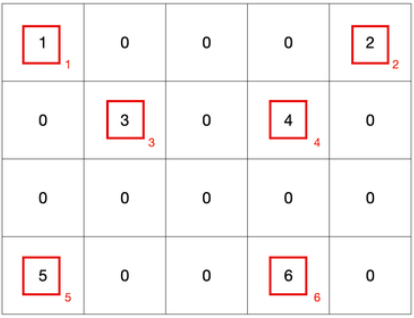

- data는 0이 아닌 원소를 차례로 기입한 값입니다.
    - data = [1, 2, 3, 4, 5, 6]
- indices는 data의 각 요소가 어느 열(column)에 있는지를 표현한 index입니다.
    - indices = [0, 4, 1, 3, 0, 3]
- indptr은 [최초시작행번호,시작행에서의 데이타 개수,두번째 행에서의 데이타 누적 개수,...,마지막행에서의 데이타 누적개수] 입니다. 이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있습니다.
    - indptr = [0, 2, 4, 4, 6]
- 이를 통해 data[0:2]는 첫 번째 행, data[2:4]는 두 번째 행, data[4:4]는 세 번째 행, data[4:6]는 네 번째 행에 위치함을 나타낼 수 있게 됩니다.

In [13]:
# CSR matrix
from scipy.sparse import csr_matrix
num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## MF 모델 학습하기
- Matrix Factorization 모델을 implicit 패키지를 사용하여 학습해 봅시다.
- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

In [14]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

## AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
- 1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [15]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [16]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [17]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 모델 학습이 끝났습니다! 이제 아래 2가지 사항을 살펴보도록 하겠습니다.

- joon벡터와 American_Beauty의 벡터를 어떻게 만들고 있는지
- 두 벡터를 곱하면 어떤 값이 나오는지

In [18]:
 joon,American_Beauty = user_to_idx['joon'],movie_to_idx['American Beauty (1999)']
joon_vector, American_Beauty_vector = als_model.user_factors[joon], als_model.item_factors[American_Beauty]

print('슝=3')

슝=3


In [19]:
joon_vector

array([-0.09781224, -0.32955253,  0.43972254,  1.3692204 ,  0.67062104,
        0.23105215,  0.07173789, -0.57602894, -0.4158995 ,  0.23289672,
        1.2350967 ,  0.6260537 , -0.04733169, -0.22394747,  0.15021315,
        0.19362983,  0.25169736, -0.9397802 , -0.18372588,  0.33305612,
       -0.42000622, -0.2159358 , -0.29589757, -1.0114485 ,  0.29976752,
        0.0704447 , -0.46197546, -1.100252  ,  0.48833448, -0.5742074 ,
       -0.7820929 ,  0.06440528,  0.9827462 ,  0.96007884,  0.04997706,
       -0.10622278,  0.56421614,  0.43447718, -0.22354813,  0.01394144,
       -0.55464476, -0.02607142, -0.59100187, -0.22516899,  1.0954905 ,
       -0.33061424,  0.35280785,  0.11532415,  1.0330732 , -0.21977644,
       -0.01702219,  0.24210247, -0.46033323,  1.1914644 , -1.1839795 ,
        0.10584675, -0.44633213,  0.01379111,  0.11259121,  0.01744618,
       -0.19287445,  0.55355686,  0.6334208 , -0.88339484, -0.51651007,
       -0.32313722,  0.4987249 , -0.9862701 , -0.07445884,  1.17

In [20]:
American_Beauty_vector

array([-0.01431463,  0.00247165, -0.01407335,  0.01787494,  0.01332007,
       -0.01199852,  0.0103521 , -0.02340212,  0.00848482, -0.00034942,
        0.02891311,  0.03133729,  0.02157517, -0.01077724, -0.00167446,
       -0.01490156,  0.00014902, -0.00269101, -0.00803618,  0.04331981,
        0.02642781, -0.01612997, -0.0061738 , -0.00067953,  0.00065676,
       -0.00157727, -0.02864008,  0.00158007, -0.00486777, -0.0345341 ,
       -0.02365926,  0.01805762, -0.0299987 ,  0.05190042,  0.01809383,
        0.0265538 ,  0.02858207,  0.00667773,  0.01793624,  0.01070719,
       -0.03623102,  0.01215961,  0.01426626,  0.01649037,  0.03450179,
       -0.03881621,  0.02716392, -0.01132659,  0.04401097,  0.03713005,
        0.03673768,  0.02076064, -0.00638207,  0.03287866, -0.01952593,
       -0.00133052, -0.01096196,  0.01603118,  0.01741868,  0.00928038,
       -0.03008887,  0.02717793,  0.0445904 , -0.0012224 , -0.00079748,
       -0.01125746,  0.03640781, -0.01891799, -0.00167901,  0.04

In [21]:
# joon과 American_Beauty를 내적하는 코드
np.dot(joon_vector, American_Beauty_vector)

0.7059061

In [22]:
# Back_to_the_Future 에 대한 선호도 예측
Back_to_the_Future = movie_to_idx['Back to the Future (1985)']
Back_to_the_Future_vector = als_model.item_factors[Back_to_the_Future]
np.dot(joon_vector, Back_to_the_Future_vector)

0.31995735

## 비슷한 영화 찾기

In [23]:
favorite_movies = 'Platoon (1986)'
movie_id = movie_to_idx[favorite_movies]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(1030, 1.0),
 (1084, 0.6484522),
 (1370, 0.6394341),
 (968, 0.5816096),
 (783, 0.55193627),
 (1300, 0.50409424),
 (728, 0.48215938),
 (1365, 0.48041925),
 (1811, 0.4772647),
 (1815, 0.46651453),
 (988, 0.45251694),
 (1723, 0.43109253),
 (1182, 0.42514858),
 (1412, 0.4113894),
 (41, 0.39396548)]

In [24]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Platoon (1986)',
 'Full Metal Jacket (1987)',
 'Killing Fields, The (1984)',
 'Last Emperor, The (1987)',
 'Deer Hunter, The (1978)',
 'Apocalypse Now (1979)',
 'Good Morning, Vietnam (1987)',
 'Patton (1970)',
 'Raging Bull (1980)',
 'Pink Floyd - The Wall (1982)',
 'Glory (1989)',
 'Birdy (1984)',
 'Red Dawn (1984)',
 'Right Stuff, The (1983)',
 'Rain Man (1988)']

In [25]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


In [26]:
get_similar_movie("Sophie's Choice (1982)")

["Sophie's Choice (1982)",
 'Places in the Heart (1984)',
 'Trip to Bountiful, The (1985)',
 'Children of a Lesser God (1986)',
 'Reds (1981)',
 'Ordinary People (1980)',
 'Way We Were, The (1973)',
 'On Golden Pond (1981)',
 'Unbearable Lightness of Being, The (1988)',
 'Driving Miss Daisy (1989)']

In [27]:
get_similar_movie('E.T. the Extra-Terrestrial (1982)')

['E.T. the Extra-Terrestrial (1982)',
 'Close Encounters of the Third Kind (1977)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Back to the Future (1985)',
 'Big (1988)',
 'Amadeus (1984)',
 'Honey, I Shrunk the Kids (1989)',
 'Dark Crystal, The (1982)',
 'Time Bandits (1981)']

## 유저에게 추천하기

In [28]:
user = user_to_idx['joon']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(120, 0.57597786),
 (60, 0.45219278),
 (87, 0.4221984),
 (170, 0.40578386),
 (23, 0.35825166),
 (26, 0.32757095),
 (22, 0.31995738),
 (160, 0.26392794),
 (124, 0.24914587),
 (157, 0.22722174),
 (5, 0.21897906),
 (126, 0.20557022),
 (607, 0.2027416),
 (27, 0.19786134),
 (121, 0.19603425),
 (172, 0.19602138),
 (92, 0.1944443),
 (0, 0.1932595),
 (193, 0.18883166),
 (271, 0.18868884)]

In [29]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Raiders of the Lost Ark (1981)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Braveheart (1995)',
 'Being John Malkovich (1999)',
 "Schindler's List (1993)",
 'E.T. the Extra-Terrestrial (1982)',
 'Back to the Future (1985)',
 'Forrest Gump (1994)',
 'Matrix, The (1999)',
 'Shawshank Redemption, The (1994)',
 'Princess Bride, The (1987)',
 'Shakespeare in Love (1998)',
 'Godfather, The (1972)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'Indiana Jones and the Last Crusade (1989)',
 'Terminator 2: Judgment Day (1991)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Alien (1979)',
 'Election (1999)']

In [30]:
Raiders = movie_to_idx['Raiders of the Lost Ark (1981)']
explain = als_model.explain(user, csr_data, itemid=Raiders)

## 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환

In [31]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Star Wars: Episode IV - A New Hope (1977)', 0.22707889110114896),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)', 0.1783097125225558),
 ('Saving Private Ryan (1998)', 0.08228597135408913),
 ('Star Wars: Episode VI - Return of the Jedi (1983)', 0.046677207123728755),
 ('American Beauty (1999)', 0.02909968886517446)]

## 회고

1. CSR matrix가 정상적으로 만들어졌다.
    - 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
    - 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
    - MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.

- CSR matrix : 사용자와 영화 제목을 기준으로 사이즈를 설정함.
- 백터 내적 수치는 0.7 정도로 준수하게 나온듯 함.
- 유사도와 기여도의 기준이 명확하지 않아 상당히 애매한 결과가 나오는것 같다.